# Libraries

In [1]:
import os
import sys
import glob


import numpy as np
import pandas as pd
import copy as cp

import scipy
import scipy.signal

from astropy.io import fits
from astropy.wcs import WCS

import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path
import more_itertools as mit

from scipy.spatial.distance import pdist, squareform

import seaborn as sns

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

In [3]:
import libs.functions as fcn
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [4]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [5]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'


abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abscatv2


# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

In [7]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [8]:
# import gp as gp
from mpfit import mpfit

# Fcn

In [236]:
def boostrap_resampling_perturb_err(a, siga):
    n_bootstrap_samples = 1000
    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    medians = np.array([np.median(a + np.random.normal(0, 3.*siga)) for _ in range(n_bootstrap_samples)])

    median_uncertainty = np.std(medians)
    mean_uncertainty = np.std(medians)
    
    return mean_uncertainty, median_uncertainty

In [9]:
def boostrap_resampling_err(data):
    n_bootstrap_samples = 1000
    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # Endfor

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)
    
    return mean_uncertainty, median_uncertainty

In [10]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read LMC catalogue

All MC sightlines

In [ ]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [19]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [20]:
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [21]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [23]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


# Detections

In [34]:
field_det = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726', 'J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

In [ ]:
ndet_total = 0
det_srcs = []
det_fields = []
for fieldn in field_det:
    field_id, fg_abs_filename, some_srcs = field_det.get(fieldn, None)
    fg_abs_filename = hires_data / fg_abs_filename
    print(field_id, fg_abs_filename, os.path.exists(fg_abs_filename))

    field = 'sb' + str(field_id)

    fg_abs_df = pd.read_csv(fg_abs_filename)
    print(f'Shape: {fg_abs_df.shape}')
    fg_abs_df.head()

    det_los = fg_abs_df[fg_abs_df['mwdet']]['comp_name'].values.tolist()
    n_det_los = len(det_los)
    print('det_los:', n_det_los)
    det_los[:4]

    det_srcs += det_los
    det_fields += [field_id]*n_det_los


    gfit_result_field_path = hires_results / field
    print(gfit_result_field_path)
    res_src_list = glob.glob(str(gfit_result_field_path / '*[0-9].pkl'))
    res_src_list = [x.replace(str(gfit_result_field_path) + '/', '').replace('.pkl', '') for x in res_src_list]
    print('res_src_list: ', len(res_src_list))
    res_src_list[:4]

    s = set(res_src_list)
    temp3 = [x for x in det_los if x not in s]
    print(temp3)

    s = set(det_los)
    temp3 = [x for x in res_src_list if x not in s]
    print(temp3)

    ndet_total += len(det_los)
# End - for
print(ndet_total)

# Read results: Read integrated properties

In [43]:
csv_filename   = hires_results / 'hires_result_table_dr3.csv' # DR3
gfit_result_df = pd.read_csv(csv_filename)
print(gfit_result_df.shape)
gfit_result_df.head(10)

(462, 42)


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220
5,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.823646,-1.913442,0.194014,0.020262,2.490387e+20,0.878501,0.551155,0.551155,0.053517,0.969827,0.137638,1.760664,0.264103,0.355924,0.063481,1.032038,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342
6,J003824-742211,30665,J003824-742211-30665,9.602613,-74.369822,304.125905,-42.728214,0,A,234.746994,0.001272,0.009595,0.539868,13.739143,1.036628,79.0,5.110,4.495,4.600000,0.496760,149.310459,0.699648,0.024721,2.311093e+21,0.328374,0.314306,0.314306,0.016083,0.586766,0.063750,2.279359,0.200747,0.204896,0.026656,1.006075,0.084653,2.866125,0.210626,2.849640,0.119482,1,3.503636
7,J004330-704147,30665,J004330-704147-30665,10.877976,-70.696568,303.881910,-46.417060,0,B,208.011002,0.000753,0.011347,0.080232,1.183264,1.036749,114.0,6.155,5.750,129.220001,0.956517,-2.563755,0.044457,0.013561,2.227711e+20,0.086494,0.096051,0.096051,0.017884,0.115427,0.039083,2.144274,0.482831,0.050945,0.021139,1.064826,0.224735,2.259701,0.484410,2.133405,0.102399,1,3.546217
8,J012930-733309,30665,J012930-733309-30665,22.375798,-73.552722,299.244025,-43.301902,0,A,168.481003,0.000750,0.031289,0.509612,4.942768,1.085753,108.0,5.360,4.965,178.339996,0.576142,0.063744,0.551402,0.064168,1.993999e+21,0.896668,0.639419,0.639419,0.025520,0.939507,0.030780,2.633537,0.134636,0.265930,0.013705,1.107691,0.051617,3.573044,0.138110,3.232634,0.079281,1,3.448888
9,J005219-722705,30665,J005219-722705-30665,13.079073,-72.451417,302.838808,-44.676675,0,A,72.601997,0.000785,0.019172,0.291124,3.276537,1.068075,94.0,5.160,4.590,49.650002,0.776951,154.999004,0.252379,0.039084,4.655635e+21,

In [226]:
# Mean FCNM
np.mean(gfit_result_df.fcnm.values)

0.2938031453275031

In [244]:
np.sqrt(np.sum(gfit_result_df.sigfcnm.values**2))/np.sqrt(462)

0.04140930681662396

In [246]:
boostrap_resampling_perturb_err(gfit_result_df.fcnm.values, gfit_result_df.sigfcnm.values)

(0.0071103931623318455, 0.0071103931623318455)

In [253]:
def bootstrap(data, num_samples=10000):
    """Perform bootstrapping on the given data."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians


# Calculate mean and median of original data
mean = np.mean(a)
median = np.median(a)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(a, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.29 ± 0.01
Median: 0.28 ± 0.01


In [256]:
def bootstrap(data, errors, num_samples=10000):
    """Perform bootstrapping on the given data with associated errors."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        # Create a sample by resampling with replacement and adding error
        indices = np.random.choice(n, size=n, replace=True)
        sample = data[indices] + np.random.normal(0, 10.*errors[indices])
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians

# Calculate mean and median of original data
mean = np.mean(a)
median = np.median(a)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(a, b, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.29 ± 0.02
Median: 0.28 ± 0.02


In [46]:
detsrc_glon = gfit_result_df.glon.values
detsrc_glat = gfit_result_df.glat.values

detsrc_ra = gfit_result_df.ra.values
detsrc_dec = gfit_result_df.dec.values

detsrc_list = gfit_result_df.comp_name.values

In [47]:
def ra_dec_to_cartesian(ra, dec):
    # Convert degrees to radians
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)
    
    # Cartesian coordinates
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    
    return x, y, z


def angular_distances(x, y, z):
    # Stack coordinates into a single array
    coords = np.vstack((x, y, z)).T
    dist_matrix = squareform(pdist(coords, metric='cosine'))
    angular_distance_rad = np.arccos(1. - dist_matrix)
    angular_distance_arcsec = np.rad2deg(angular_distance_rad) * 3600
    return angular_distance_arcsec


def filter_distances(distances, min_distance, max_distance):
    indices = np.where((distances > min_distance) & (distances < max_distance))
    unique_pairs = [(i, j) for i, j in zip(indices[0], indices[1]) if i < j]
    return unique_pairs

In [48]:
# Convert to Cartesian coordinates
x, y, z = ra_dec_to_cartesian(detsrc_ra, detsrc_dec)

# Calculate angular distances in arcseconds
distances = angular_distances(x, y, z)

# Filter distances
min_distance = 50.  # arcseconds
max_distance = 60.  # arcseconds

close_targets = filter_distances(distances, min_distance, max_distance)
print(len(close_targets))
print(close_targets)

# Display results
for pair in close_targets:
    print(f"Target {pair[0]} and Target {pair[1]} are close with an angular distance between {min_distance} arcseconds and {max_distance} arcseconds.")


4
[(309, 361), (312, 313), (417, 418), (450, 457)]
Target 309 and Target 361 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 312 and Target 313 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 417 and Target 418 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 450 and Target 457 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.


# Read CNM components

In [50]:
csv_filename = hires_results / 'hires_result_CNM_components_dr3.csv' # DR3
gfit_cpn_result_df = pd.read_csv(csv_filename)
print(gfit_cpn_result_df.shape)
gfit_cpn_result_df.head(10)

(691, 39)


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
5,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.250228,0.006430,0.012771,-0.990880,0.035323,3.092582,0.079347,56.806365,4.810935,12.278083,0.769829,0.868798,0.054916,0.237473,0.040371,3.658516,0.577369,3.473220,0.852766,0.078579
6,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.090734,0.014163,0.014662,-2.045776,0.094471,1.604501,0.283611,39.228026,16.332487,9.751173,0.798455,0.104369,0.047078,0.038223,0.017739,2.730491,0.297817,3.555342,0.110785,0.053010
7,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.099096,0.012114,0.014662,-1.024331,0.180142,4.963483,0.338277,92.364982,12.186470,10.372669,0.798455,0.865458,0.129336,0.316961,0.058642,2.730491,0.297817,3.555342,0.881302,0.169516
8,J003824-742211,30665,J003824-742211-30665,9.602613,-74.369822,304.125905,-42.728214,0,A,234.746994,0.001272,0.009595,0.539868,13.739143,1.036628,79.0,5.110,4.495,4.600000,0.089794,0.003819,0.009851,-1.153054,0.078004,3.947628,0.178987,83.949909,10.997951,7.053374,0.896473,0.586766,0.063750,0.204725,0.026853,2.866125,0.210626,3.503636,0.577268,0.083707
9,J004330-704147,30665,J004330-704147-30665,10.877976,-70.696568,303.881910,-46.417060,0,B,208.011002,0.000753,0.011347,0.080232,1.183264,1.036749,114.0,6.155,5.750,129.220001,0.043047,0.005625,0.011567,-2.794035,0.138133,2.203807,0.321730,65.769937,22.157281,2.356820,1.076401,0.115427,0.039083,0.051081,0.020471,2.259701,0.484410,3.546217,0.121037,0.047170


In [ ]:
src_list = gfit_cpn_result_df.uniq_name.values
for k,srci in enumerate(src_list):
    if k == 2:
        print(srci)
        src_df = gfit_cpn_result_df[gfit_cpn_result_df.uniq_name == srci]
        src_ts = src_df.tscnm.values
        src_nhicnm = src_df.nhicnm_cpn.values
        print(src_ts)
        print(src_nhicnm)
        avg_ts = np.average(src_ts, weights=src_nhicnm)
        print(avg_ts)

# CNM with Ts < 250

In [53]:
gfit_cnm_cpn_df = gfit_cpn_result_df[gfit_cpn_result_df.tscnm < 250.5]
gfit_cnm_cpn_srcs = gfit_cnm_cpn_df.comp_name.unique()
gfit_cnm_cpn_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,1.381515,0.385456,0.233672,0.755664,0.165140,2.210733,0.338032,27.020567,3.721899,17.238146,0.453207,1.416348,0.171045,0.225989,0.028857,6.267342,0.260013,3.515802,1.600893,0.555026
687,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.421614,0.017670,0.023883,7.434009,0.035521,2.055398,0.079110,35.538772,4.928284,10.852738,0.790409,0.572984,0.057847,0.134791,0.073315,4.250919,2.271969,3.430639,0.597434,0.089552
688,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.265958,0.017947,0.037130,7.076890,0.102529,3.626937,0.234743,59.134648,3.256338,14.051706,0.503125,1.140123,0.059094,0.253422,0.017857,4.498908,0.214756,3.409348,1.106552,0.120073
689,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.176693,0.020038,0.037130,-0.000135,0.126679,2.513307,0.290737,77.354570,5.335641,12.817144,0.503125,0.687252,0.052560,0.152760,0.013772,4.498908,0.214756,3.409348,0.666387,0.117329


# Optical depth

In [57]:
# Optical depth
fg_taucnm = gfit_cpn_result_df.taucnm.values
sig_tau_noise = gfit_cpn_result_df.sigtaunoise.values
fg_sigtaucnm = gfit_cpn_result_df.sigtaucnm.values
glon = gfit_cpn_result_df.glon.values
glat = gfit_cpn_result_df.glat.values

total_ncnm = len(fg_taucnm)
print(f'Total CNM components: {total_ncnm}')

Total CNM components: 691


In [58]:
stats_series = pd.DataFrame(fg_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,0.474371
std,0.441789
min,0.014090
25%,0.159337
50%,0.353273
75%,0.646146
max,2.915342


In [59]:
tau_count = int(series_values[0])
tau_mean = round(series_values[1], 2)
tau_std = round(series_values[2], 2)
tau_minval = round(series_values[3], 4)
tau_maxval = round(series_values[-1], 4)
tau_median = round(series_values[5], 2)
tau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
tau_stats_values = [tau_count, tau_mean, tau_median, tau_std, tau_minval, tau_maxval]

In [60]:
sig_tau_noise = np.asarray(sig_tau_noise)
low_sigtau_id = np.where(sig_tau_noise < 0.05)[0]
hgt_sigtau_id = np.where(sig_tau_noise >= 0.05)[0]

In [62]:
fg_sigtaucnm_lownoise = fg_sigtaucnm[low_sigtau_id]

In [64]:
# Optical depth
taumin = min(fg_taucnm)
taumax = max(fg_taucnm)

gl_tau  = np.array(glon)
gb_tau  = np.array(glat)

ind_tau = np.argsort(fg_taucnm)
ind_tau = ind_tau[::-1]
taucnm_sorted = fg_taucnm[ind_tau]
gl_tau = gl_tau[ind_tau]
gb_tau = gb_tau[ind_tau]

In [66]:
stats_series = pd.DataFrame(fg_sigtaucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,0.064019
std,0.116306
min,0.001003
25%,0.013715
50%,0.028623
75%,0.070638
max,1.745435


In [67]:
sigtau_count = int(series_values[0])
sigtau_mean = round(series_values[1], 1)
sigtau_std = round(series_values[2], 1)
sigtau_minval = round(series_values[3], 1)
sigtau_maxval = round(series_values[-1], 1)
sigtau_median = round(series_values[5], 1)
sigtau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
sigtau_stats_values = [sigtau_count, sigtau_mean, sigtau_median, sigtau_std, sigtau_minval, sigtau_maxval]
sigtau_units = ['', '', '', '', '', '']

# HI spin temperature

In [70]:
tscnm = gfit_cpn_result_df.tscnm.values
sigtscnm = gfit_cpn_result_df.sigtscnm.values
nhicnm_cpn = gfit_cpn_result_df.nhicnm_cpn.values
signhicnm_cpn = gfit_cpn_result_df.signhicnm_cpn.values

In [71]:
stats_series = pd.DataFrame(tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,60.108511
std,40.618373
min,11.278219
25%,34.908276
50%,49.985345
75%,71.759273
max,307.047625


In [72]:
ts_count = int(series_values[0])
ts_mean = round(series_values[1], 1)
ts_std = round(series_values[2], 1)
ts_minval = round(series_values[3], 1)
ts_maxval = round(series_values[-1], 1)
ts_median = round(series_values[5], 1)
ts_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
ts_stats_values = [ts_count, ts_mean, ts_median, ts_std, ts_minval, ts_maxval]
ts_units = ['', 'K', 'K', 'K', 'K', 'K']

In [74]:
tsmin = min(tscnm)
tsmax = max(tscnm)

gl_ts  = np.array(glon)
gb_ts  = np.array(glat)

ind_ts = np.argsort(tscnm)
ind_ts = ind_ts[::-1]
tscnm_sorted = tscnm[ind_ts]
gl_ts  = gl_ts[ind_ts]
gb_ts  = gb_ts[ind_ts]

## Purely from radiative transfer

In [85]:
# Const
mh = 1.6737236e-24 # gram

# Const
m_h = 1.6737236e-27 # kg

dz  = 40./1024. #pc Saury14
print('Saury14 dz: ', dz)

dz  = 200./512. #pc seta22
print('Seta22 dz: ', dz)




# Velocity range and channel spacing
vmin = -50. #km.s-1
vmax = 50. #km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
at_v = np.arange(vmin, vmax+dv, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
nchan = len(v)
print('nchan: ', nchan)


constC = 1.8224e18
dz = 0.03 # pc
print('Current dz (pc): ', dz)

parsec_to_cm = 3.086e18  # 1 parsec in cm
dz_cm = parsec_to_cm*dz

Saury14 dz:  0.0390625
Seta22 dz:  0.390625
nchan:  320
Current dz (pc):  0.03


In [87]:
# Parameters
v0 = 0.      # Mean velocity in km/s
m = 1.6735575e-27  # Mass of a hydrogen atom in kg
k_B = 1.380649e-23  # Boltzmann constant in J/K

In [194]:
print('WNM: ', np.min(nhiwnm_cpn), np.mean(nhiwnm_cpn), np.median(nhiwnm_cpn), np.max(nhiwnm_cpn))
print('CNM: ', np.min(nhicnm_cpn), np.mean(nhicnm_cpn), np.median(nhicnm_cpn), np.max(nhicnm_cpn))

WNM:  0.3503537403715147 3.3197756195902617 3.267598165230983 6.885130928973069
CNM:  0.0576145285945872 1.2084212478432996 0.9219518551412512 4.735151053355293


In [195]:
print('CNM: ', np.min(nhicnm_los), np.mean(nhicnm_los), np.median(nhicnm_los), np.max(nhicnm_los))
print('WNM: ', np.min(nhiwnm_los), np.mean(nhiwnm_los), np.median(nhiwnm_los), np.max(nhiwnm_los))

CNM:  0.0939460505027575 1.807400610951775 1.5714955596229516 6.098604392015569
WNM:  1.3575417840221675 4.095827063130843 3.9214201915097098 7.651086783011179


In [218]:
sum_cnm = np.sum(nhicnm_los)
sigsum_cnm = np.sqrt(np.sum(signhicnm_los**2))
sum_wnm = np.sum(nhiwnm_los)
sigsum_wnm = np.sqrt(np.sum(signhiwnm_los**2))
sum_cnm_wnm = sum_cnm + sum_wnm
sigsum_cnm_wnm = np.sqrt(sigsum_cnm**2 + sigsum_wnm**2)
print('CNM sum:', sum_cnm, '+/-', sigsum_cnm)
print('WNM sum:', sum_wnm, '+/-', sigsum_wnm)
print('CNM+WNM sum:', sum_cnm_wnm,  '+/-', sigsum_cnm_wnm)

CNM sum: 835.0190822597201 +/- 8.71585025719234
WNM sum: 1892.2721031664491 +/- 14.936464753318033
CNM+WNM sum: 2727.2911854261692 +/- 17.293467698322154


In [219]:
print('CNM_sum / WNM_sum: ', sum_cnm/sum_wnm)
print('CNM_sum / total_sum: ', sum_cnm/sum_cnm_wnm)
sigfcnm_final = fitlibs.uncertainty_of_ratio(sum_cnm, sum_cnm_wnm, sigsum_cnm, sigsum_cnm_wnm)
print(sigfcnm_final)

CNM_sum / WNM_sum:  0.4412785459672708
CNM_sum / total_sum:  0.30617159132908617
0.003739266805110727


In [163]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
print(outfile1)
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

/Users/kiemhiep/ANU/ASKAP/data/LMC/Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
(3500, 5100)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5100                                                  
NAXIS2  =                 3500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2550.0 / Pixel coordinate of reference point            
CRPIX2  =               1750.0 / Pixel coordinate of reference point            
CDELT1  =          -0.00666666 / [deg] Coordinate increment at reference point  
CDELT2  =           0.00666666 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-TAN'        

# R - opacity correction factor

In [170]:
rhi = gfit_result_df['Rfactor'].values
sigrhi = gfit_result_df['sigRfactor'].values
rhi[rhi < 0.98] = 0.98

In [171]:
nhi_tot = gfit_result_df.nhi.values
signhi_tot = gfit_result_df.signhi.values

mc_src_gl = gfit_result_df.glon.values
mc_src_gb = gfit_result_df.glat.values

In [172]:
stats_series = pd.DataFrame(rhi).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,462.000000
mean,1.091914
std,0.085798
min,0.980000
25%,1.032019
50%,1.068472
75%,1.125017
max,1.469291


In [173]:
rhi_count = int(series_values[0])
rhi_mean = round(series_values[1], 2)
rhi_std = round(series_values[2], 2)
rhi_minval = round(series_values[3], 4)
rhi_maxval = round(series_values[-1], 2)
rhi_median = round(series_values[5], 2)
rhi_labels = ['Mean', 'Median', 'std', 'Min', 'Max']
rhi_stats_values = [rhi_mean, rhi_median, rhi_std, rhi_minval, rhi_maxval]
rhi_units = ['', '', '', '', '']

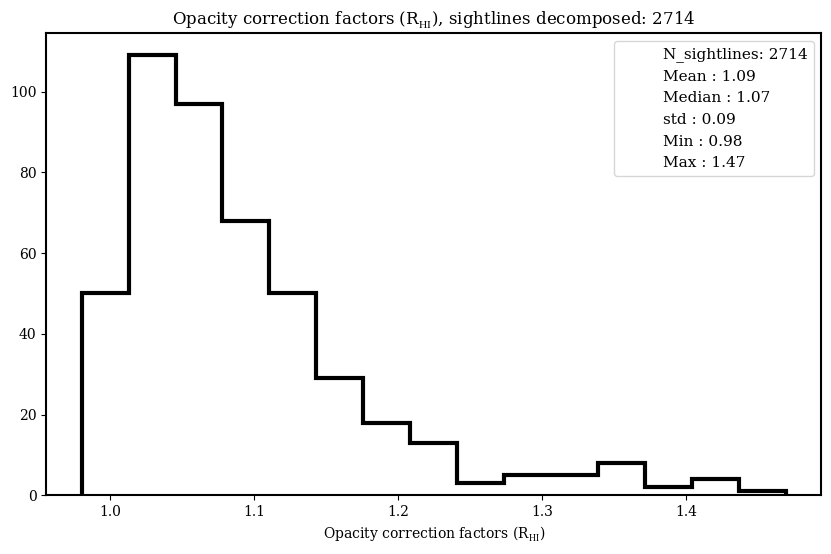

In [174]:
# R - Opacity correction factor
plt.figure(figsize=(10, 6))

# sns.histplot(data=rhi, bins=40, kde=False)
plt.hist(rhi, bins=15,
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='')

ploti, = plt.plot([], [], '', label=f"N_sightlines: {nrows}")
ploti.set_visible(False)

for labeli,vali, uniti in zip(rhi_labels, rhi_stats_values, rhi_units):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali} {uniti}")
    ploti.set_visible(False)

plt.title(r'Opacity correction factors (R$_\mathrm{HI}$), ' + f'sightlines decomposed: {nrows}')
plt.xlabel(r'Opacity correction factors (R$_\mathrm{HI}$)')

plt.legend(loc='upper right', fontsize=11)
plt.show()

In [175]:
rhi_min = min(rhi)
rhi_max = max(rhi)

In [179]:
thinR = np.zeros(ndet_total)
for j, src in enumerate(gfit_result_df.comp_name.values):
    # Infor of the source
    src_info  = fcn.get_source_info_by_name(df, src)
    field    = 'sb' + str(src_info['sbid'])

    # READ RESULTS FROM THE GAUSSIAN DECOMPOSITION
    src_path = hires_results / field / (src + '.pkl')
    with open(src_path, 'rb') as xfile:
        ret = pickle.load(xfile)
    xfile.close()
    
    abs_filename = ret['abs_file']
    csv_file     = ret['csv_file']
    pkl_file     = ret['pkl_file']
    src_info_ret = ret['src_info']
    
    # Emission profiles
    vlsr = ret['vlsr']
    dv      = np.abs(np.diff(vlsr)[0])
    Npix = ret['n_profiles']
    nchan = ret['nchans']
    em_spectra = ret['EM_profiles'].T
    texp = np.mean(em_spectra, axis=0)

    thin, thiner = fitlibs.cal_optthin_nhi_gaskap(vlsr, texp)
    thinR[j] = thin

In [ ]:
if True:
    nhiGN = np.zeros(ndet_total)
    tsra  = np.arange(101.5, 103.5, 0.5)
    s2    = np.zeros(len(tsra))
    jj    = 0

    for ts in tsra:
        for j, src in enumerate(gfit_result_df.comp_name.values):

            # Infor of the source
            src_info      = fcn.get_source_info_by_name(df, src)
            field    = 'sb' + str(src_info['sbid'])

            # READ RESULTS FROM THE GAUSSIAN DECOMPOSITION
            src_path = hires_results / field / (src + '.pkl')
            with open(src_path, 'rb') as xfile:
                ret = pickle.load(xfile)
            xfile.close()
            
            abs_filename = ret['abs_file']
            csv_file     = ret['csv_file']
            pkl_file     = ret['pkl_file']
            src_info_ret = ret['src_info']
            
            # Emission profiles
            vlsr = ret['vlsr']
            dv      = np.abs(np.diff(vlsr)[0])
            Npix = ret['n_profiles']
            nchan = ret['nchans']
            em_spectra = ret['EM_profiles'].T
            texp = np.mean(em_spectra, axis=0)

            for kk,teval in enumerate(texp):
                if(teval >= 0.99*ts):
                    texp[kk] = 0.99*ts

            temp     = np.log(1.0 - texp/ts)
            NHIcor   = -1.8224e-2*ts*dv*temp ## unit of 1e20
            
            idx      = np.where( (vlsr >= -100.) & (vlsr <= 100.) )
            vGN      = vlsr[idx]
            NHIcor   = NHIcor[idx]
            
            nhiGN[j] = np.sum(NHIcor)
        # End - for: src

        print(len(nhiGN))
        ratio  = nhiGN/thinR

        diff   = np.abs(ratio - rhi)
        s2[jj] = np.sqrt(np.sum(diff**2))
        jj     = jj + 1
    ## Endfor


    ## Plot chi2 vs ts ##
    plt.figure()
    plt.plot(tsra, s2, 'r.')
    plt.xlabel('Tspin')
    plt.ylabel('chi2 - all')
    plt.show()
    plt.close('all')
    sys.exit()
    ## End - plot ##

In [ ]:
## Then do again with best Ts ##
nhiGN = np.zeros(ndet_total)
ts    = 102.5
for j, src in enumerate(gfit_result_df.comp_name.values):
    # Infor of the source
            src_info      = fcn.get_source_info_by_name(df, src)
            field    = 'sb' + str(src_info['sbid'])

            # READ RESULTS FROM THE GAUSSIAN DECOMPOSITION
            src_path = hires_results / field / (src + '.pkl')
            with open(src_path, 'rb') as xfile:
                ret = pickle.load(xfile)
            xfile.close()
            
            abs_filename = ret['abs_file']
            csv_file     = ret['csv_file']
            pkl_file     = ret['pkl_file']
            src_info_ret = ret['src_info']
            
            # Emission profiles
            vlsr = ret['vlsr']
            dv      = np.abs(np.diff(vlsr)[0])
            Npix = ret['n_profiles']
            nchan = ret['nchans']
            em_spectra = ret['EM_profiles'].T
            texp = np.mean(em_spectra, axis=0)

            for kk,teval in enumerate(texp):
                if(teval >= 0.99*ts):
                    texp[kk] = 0.99*ts

            temp     = np.log(1.0 - texp/ts)
            NHIcor   = -1.8224e-2*ts*dv*temp ## unit of 1e20
            
            idx      = np.where( (vlsr >= -100.) & (vlsr <= 100.) )
            vGN      = vlsr[idx]
            NHIcor   = NHIcor[idx]
            
            nhiGN[j] = np.sum(NHIcor)
        # End - for: src
## Endfor

## Calc. ratio
ratio  = nhiGN/thinR

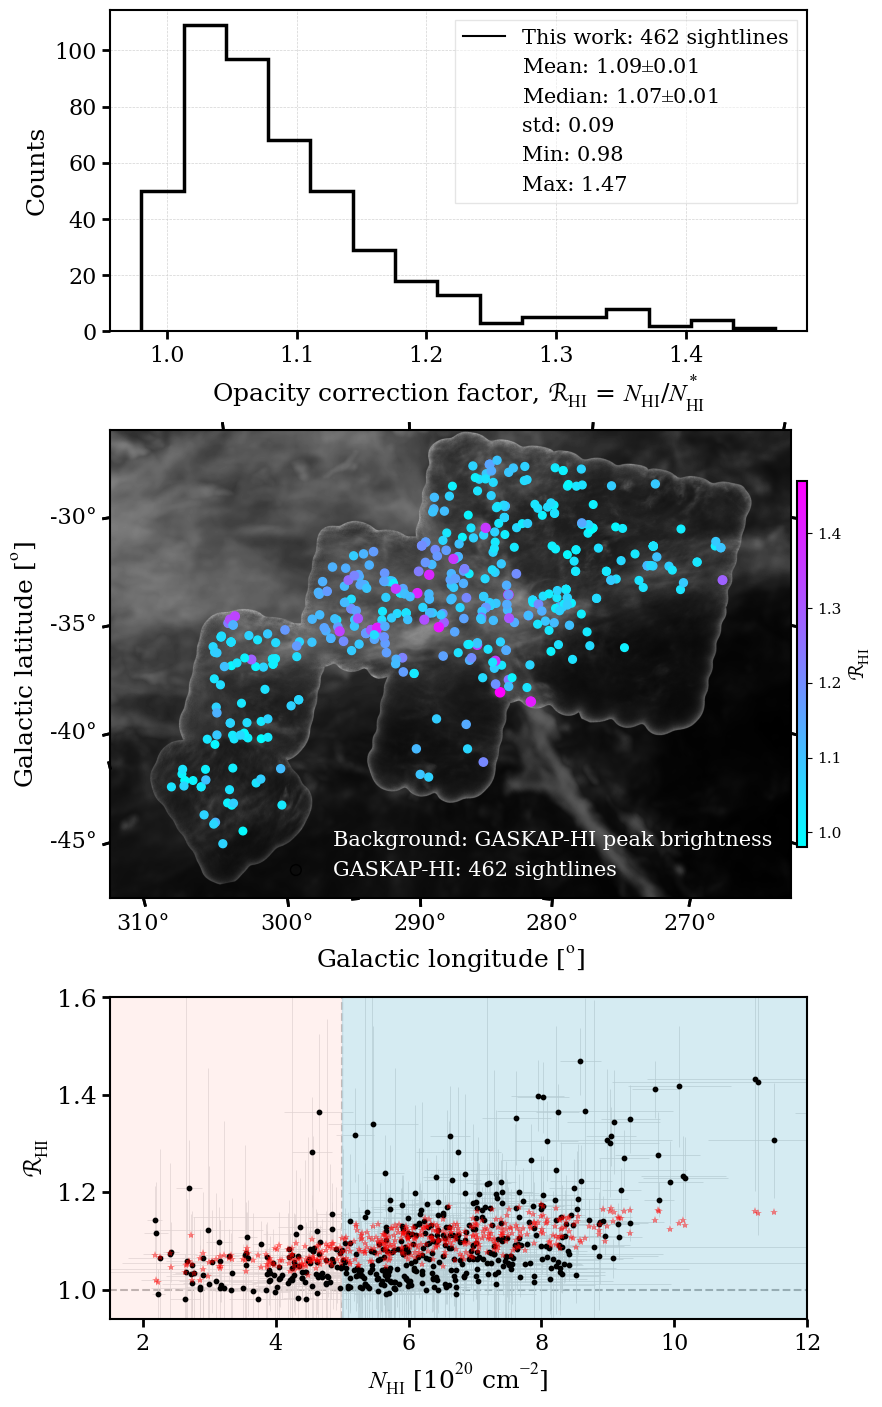

In [ ]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"


fig = plt.figure(figsize=(9,17))

gs = gridspec.GridSpec(8, 5)
ax1 = plt.subplot(gs[0:2, 0:5])

xylabel = 18
xytlabel = 16
lgsize = 15


# RHI
ax1.hist(rhi, bins=15,
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=2.5,
         label='')

ploti, = ax1.plot([], [], 'k-', label=f'This work: {ndet_total} sightlines')
ploti.set_visible(True)
    
for labeli,vali, uniti in zip(rhi_labels, rhi_stats_values, rhi_units):
    err = ''
    if labeli == 'Mean':
        ploti, = plt.plot([], [], '', label=f'{labeli}: {vali}' + r'$\pm$' + f'{0.01:0.2f} {uniti}')
    elif labeli == 'Median':
        ploti, = plt.plot([], [], '', label=f'{labeli}: {vali}' + r'$\pm$' + f'{0.01:0.2f} {uniti}')
    else:
        ploti, = plt.plot([], [], '', label=f'{labeli}: {vali:0.2f} {uniti}')

    ploti.set_visible(False)

ax1.set_xlabel(r'Opacity correction factor, $\mathcal{R}_\mathrm{HI}$ = $N_\mathrm{HI}$/$N^*_\mathrm{HI}$', fontsize=xylabel)
ax1.set_ylabel('Counts', fontsize=xylabel)

ax1.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax1.tick_params(axis='y', labelsize=xytlabel)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=6)
ax1.tick_params(which='minor', length=4)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax1.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=lgsize)











# Plot: RHI
ax2 = plt.subplot(gs[2:6, 0:], projection=WCS(fg_hdr))


cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display the moment map image
im = ax2.imshow(tbpeak_data, cmap='gray')

sct = ax2.scatter(mc_src_gl, mc_src_gb,
                  zorder=0, s=rhi*30,
                  c=rhi, marker='o', cmap=cm,
                  vmin=np.min(rhi), vmax=np.max(rhi),
                  transform=ax2.get_transform('galactic'),
                  label='')


ploti, = ax2.plot([], [], '', label=f"Background: GASKAP-HI peak brightness")
ploti.set_visible(False)

ploti = ax2.scatter([], [], marker='o', s=60, edgecolors='k', facecolors='none', label=f'GASKAP-HI: {ndet_total} sightlines')
ploti.set_visible(True)


# Add axes labels
ax2.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=xylabel)
ax2.set_ylabel(r'Galactic latitude [$^\mathrm{o}$]', fontsize=xylabel)

ax2.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax2.tick_params(axis='y', labelsize=xytlabel)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=6)
ax2.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(sct, ax=ax2, orientation='vertical', fraction=0.015, pad=0.0075, aspect=35)
cbar.ax.set_ylabel(r'$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=11)

ax2.legend(loc='lower right', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=15)









# ax3
ax3 = plt.subplot(gs[6:, 0:])
ax3.errorbar(nhi_tot, rhi,
             xerr=signhi_tot, yerr=sigrhi, zorder=1, 
             color='k', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')
sct2 = ax3.scatter(nhi_tot, rhi, zorder=2, c='k', s=10, marker='o', vmin=0., vmax=37., label='')

ax3.plot(nhi_tot, ratio, color=None, markerfacecolor='r', marker='*', ls='None', markersize=6, markeredgecolor='r', markeredgewidth=0, alpha=0.48, label='$\mathrm{N_{HI}}\ (\mathrm{T_s}{\sim}'+str(ts)+'K)$')

ax3.axvspan(0., 5., ymin=0., ymax=30., alpha=0.5, color='mistyrose') 
ax3.axvspan(5., 12., ymin=0., ymax=30., alpha=0.5, color='lightblue')

ax3.plot([5., 5.], [0.94, 1.6], c='gray', ls='--', zorder=0)
ax3.plot([1., 12.], [1., 1.], c='gray', ls='--', zorder=0)


ax3.set_xlabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xylabel)
ax3.set_ylabel(r'$\mathcal{R}_\mathrm{HI}$', fontsize=xylabel)

ax3.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax3.tick_params(axis='y', labelsize=xylabel)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=6)
ax3.tick_params(which='minor', length=4)

ax3.set_xlim(1.5, 12.)
ax3.set_ylim(0.94, 1.6)







# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.0,
                    hspace=0.05
                    )



plt.show()